In [11]:
# %load_ext autoreload
# %autoreload 2
# from nn.value import Value
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from nn.value import Value, exp, log
from nn.module import Layer,MLP, Relu, Tanh, Softmax

%matplotlib inline
np.random.seed(1337)
random.seed(1337)

# Regression

In [12]:
from sklearn.datasets import make_regression
X, y = X_raw, y_raw = make_regression(n_samples=50, n_features=10)
y = (y-y.mean()) / y.std()

In [17]:
# FIXME something seems wrong with tanh?  maybe some under/overflow?
net = MLP(10, [10,10, 1], act=Tanh)

In [18]:
X=[[x_ for x_ in x]for x in X_raw]
batch_size = len(X)
lr = .1

for i in range(50):
    #forward
    y_logits = [net(x) for x in X]

    # hacky MSE loss
    loss = sum((y1-y2)**2  for y1, y2 in zip(y_logits, y)) / batch_size
    loss = loss[0]

    #backward
    for p in net.parameters():
        p.grad = 0

    loss.backward()
    # print(mlp.parameters())
    print(i, 'loss', loss.data)#, 'reg_loss', reg_loss.data)
    # for p in net.parameters():
    #     print(f'{p.name}={p.data:.2f} grad={p.grad:.5f}')
    
    for p in net.parameters():
        p.data -= p.grad * lr

0 loss 1.385445093336359
1 loss 0.9467515035808504
2 loss 0.7982455830219525
3 loss 0.8190474371216335
4 loss 1.0213269351818781
5 loss 1.50483573894358
6 loss 2.1667995621805813
7 loss 2.397842665617828
8 loss 2.0831672559306167
9 loss 1.7217026668891293
10 loss 1.4335525989689797
11 loss 1.2216395658895505
12 loss 1.0557596783767864


KeyboardInterrupt: 

In [177]:
# for p in net.parameters():
#     print(f'{p.name}={p.data:.2f} grad={p.grad:.5f}')


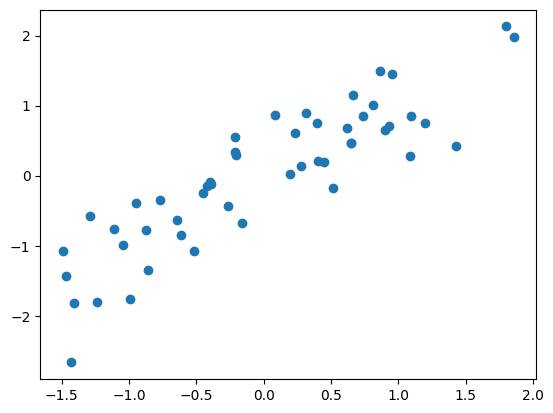

In [178]:
y_pred = [[y_.data for y_ in y] for y in y_logits]
plt.scatter(y_pred, y)

# Classification

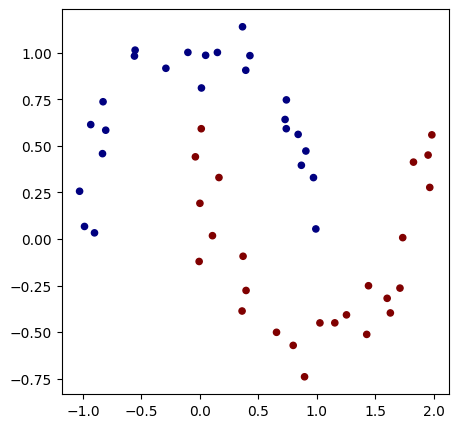

In [2]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X_raw, y_raw = X, y = make_moons(n_samples=50, noise=0.1)

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [7]:
# doesn't work yet...
net = MLP(2, [16,2], act=Tanh)

In [8]:
batch_size = len(X)
lr = .1
    
for i in range(100):
    lr = .1# * ((30-i)/30)
    
    #forward
    y_logits = [net(x) for x in X]
    y_probs = [Softmax()(x) for x in y_logits]

    # nll loss
    nll_loss = sum(-log(y_probs_[y_true]) for y_probs_, y_true in zip(y_probs, y)) / batch_size
    # L2
    # reg_loss = 1e-3 * sum(p**2 for p in net.parameters()) / batch_size
    loss = nll_loss #+ reg_loss
        
    #backward
    for p in net.parameters():
        p.grad = 0

    loss.backward()
    # print(mlp.parameters())
    # if i==0 or i % 10 == 0:
    y_probas = np.array([[y_probs__.data for y_probs__ in y_probs_] for y_probs_ in y_probs ])
    acc = (y_probas.argmax(1) == y).mean()
    print(i, 'loss', loss.data, 'nll_loss', nll_loss.data, 'acc', acc)#, 'reg_loss', reg_loss.data)
    # for p in net.parameters():
    #     print(f'{p.name}={p.data:.2f} grad={p.grad:.5f}')
    
    for p in net.parameters():
        p.data -= p.grad * lr

0 loss 0.7948143506493761 nll_loss 0.7948143506493761 acc 0.62
1 loss 0.8127532233705624 nll_loss 0.8127532233705624 acc 0.62
2 loss 0.8307730516037874 nll_loss 0.8307730516037874 acc 0.62
3 loss 0.8497686998839119 nll_loss 0.8497686998839119 acc 0.66
4 loss 0.8660183778097431 nll_loss 0.8660183778097431 acc 0.62
5 loss 0.8736020026780755 nll_loss 0.8736020026780755 acc 0.6
6 loss 0.867634946515279 nll_loss 0.867634946515279 acc 0.56
7 loss 0.8470185541246872 nll_loss 0.8470185541246872 acc 0.52
8 loss 0.8163134902366145 nll_loss 0.8163134902366145 acc 0.46
9 loss 0.785371772191498 nll_loss 0.785371772191498 acc 0.46
10 loss 0.7655114589000331 nll_loss 0.7655114589000331 acc 0.46
11 loss 0.7643331251308557 nll_loss 0.7643331251308557 acc 0.44
12 loss 0.7833862437135227 nll_loss 0.7833862437135227 acc 0.48
13 loss 0.8198741272787488 nll_loss 0.8198741272787488 acc 0.54
14 loss 0.8691547152872952 nll_loss 0.8691547152872952 acc 0.56
15 loss 0.9260159708476454 nll_loss 0.9260159708476454 

In [187]:
for p in net.parameters():
    print(f'{p.name}={p.data:.2f} grad={p.grad:.5f}')

w=-0.23 grad=0.52681
w=-0.32 grad=-0.35669
None=0.08 grad=-0.66519
w=0.37 grad=-0.24176
w=-0.72 grad=0.01553
None=0.06 grad=0.50252
w=0.40 grad=-0.11674
w=-0.65 grad=-0.07334
None=0.07 grad=-0.30540
w=0.18 grad=-0.88295
w=1.02 grad=-0.07469
None=0.27 grad=-1.43151
w=-0.71 grad=-0.13144
w=-0.38 grad=0.52310
None=-0.48 grad=1.03542
w=-1.03 grad=-0.07567
w=0.34 grad=0.36860
None=-0.19 grad=0.58066
w=-0.47 grad=-0.08871
w=0.16 grad=0.22134
None=-0.41 grad=0.57427
w=0.79 grad=-0.03469
w=0.04 grad=-0.45557
None=0.26 grad=-1.17918
w=0.83 grad=-0.18570
w=-0.08 grad=0.23276
None=0.35 grad=0.87154
w=0.55 grad=0.36260
w=-0.09 grad=0.47651
None=-0.02 grad=1.26371
w=-0.38 grad=-0.63878
w=-0.35 grad=-0.25579
None=0.37 grad=-0.50669
w=-0.97 grad=-0.03738
w=0.45 grad=-0.14879
None=-0.21 grad=-0.48743
w=-0.14 grad=0.32307
w=0.13 grad=0.16795
None=0.13 grad=0.52435
w=0.07 grad=-0.32975
w=0.51 grad=-0.48950
None=0.14 grad=-0.78353
w=0.21 grad=0.20331
w=-0.08 grad=-0.02413
None=0.56 grad=0.04080
w=0.68 gr

In [81]:
# inputs

(-1.5519886177574858, 1.9480113822425142)

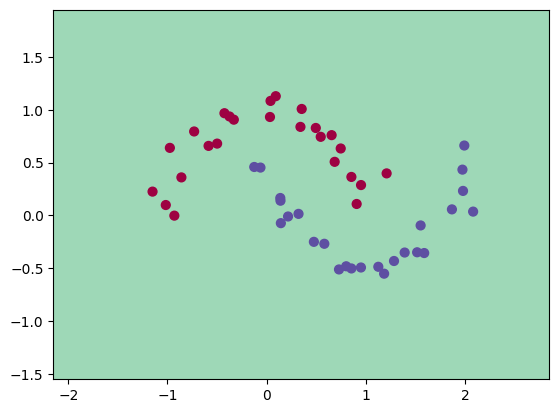

In [39]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = [max(x.data for x in net(i)) for i in inputs]
Z = np.array([s > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
